In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

data = pd.read_csv("terror.csv",encoding='ISO-8859-1')
data = data[["iyear","imonth","iday","country","country_txt","extended","region",
            "region_txt","provstate","summary","success","suicide","attacktype1","attacktype1_txt"
            ,"targtype1","targtype1_txt","natlty1","gname","weaptype1","weaptype1_txt","nkill","nwound"
           ]]

C:\Users\gneur\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data["weaptype1_txt"].unique()

array(['Unknown', 'Explosives', 'Incendiary', 'Firearms', 'Chemical',
       'Melee', 'Sabotage Equipment',
       'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'Fake Weapons', 'Radiological', 'Other', 'Biological'],
      dtype=object)

In [3]:
data = data.dropna(axis=0, subset=['summary',"provstate","nwound"])
data = data.drop_duplicates(subset=["summary"])
data.reset_index(inplace=True,drop=True)
data = data[data["iyear"] > 1990]


{'whiskers': [<matplotlib.lines.Line2D at 0x245df10c7f0>,
 'caps': [<matplotlib.lines.Line2D at 0x245df0789b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x245df10ccc0>],
 'medians': [<matplotlib.lines.Line2D at 0x245df078048>],
 'fliers': [<matplotlib.lines.Line2D at 0x245df0762b0>],
 'means': []}

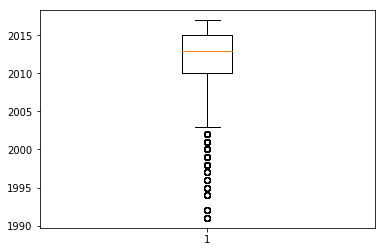

In [4]:
plt.boxplot(data["iyear"])

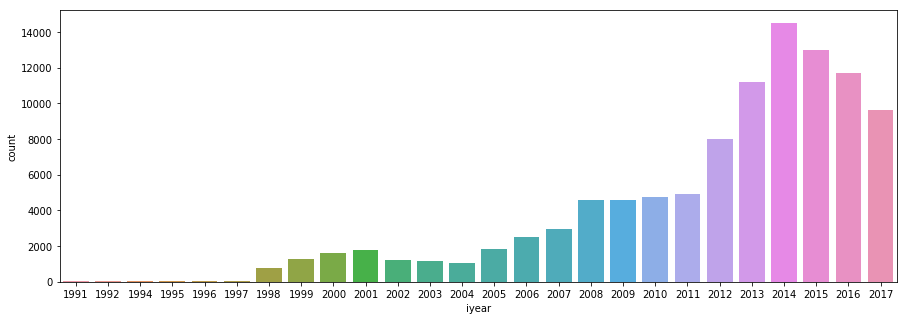

In [5]:
fig = plt.figure(figsize = (15,5))
fig = sns.countplot(data["iyear"])
plt.show()

In [6]:
country = data["country_txt"].value_counts() 
country = country[country >40]
country

Iraq                                21966
Pakistan                            12148
Afghanistan                         11598
India                                8592
Philippines                          4761
Thailand                             3460
Somalia                              2972
Yemen                                2803
Nigeria                              2792
Colombia                             2129
Egypt                                1888
Libya                                1876
Russia                               1876
Turkey                               1850
Algeria                              1507
Ukraine                              1472
Syria                                1457
West Bank and Gaza Strip             1279
United Kingdom                       1193
Israel                               1108
Nepal                                1105
Bangladesh                           1044
Sri Lanka                             867
United States                     

In [7]:
data["no_punct"] = data['summary'].str.replace('[^\w\s]','')

from nltk.corpus import stopwords
stop = stopwords.words('english')

data["modded"] = data['summary'].apply(lambda x: [item.lower() for item in x.split() if item not in stop])


In [8]:
summaries = [el[1:] for el in data["modded"]]

[['unknown',
  'perpetrators',
  'placed',
  'homemade',
  'pipe',
  'bomb',
  'restroom',
  'islamic',
  'center',
  'san',
  'diego',
  'california,',
  'united',
  'states.',
  'the',
  'device',
  'discovered',
  'subsequently',
  'removed',
  'detonating.',
  'this',
  'incident',
  'occurred',
  'gulf',
  'war.'],
 ['a',
  'bomb',
  'detonated',
  'near',
  'thomas',
  'jefferson',
  'cultural',
  'center',
  'manila,',
  'philippines.',
  'the',
  'casualties',
  'perpetrators,',
  'abdul-kadhim',
  'saad',
  'ahmed',
  'j.',
  'ahmed,',
  'detonated',
  'device',
  'prematurely',
  'set',
  'timer.',
  'ahmed',
  'killed,',
  'body',
  'found',
  'roof',
  'house',
  '35',
  'feet',
  'away.',
  'saad',
  'wounded.',
  'the',
  'explosion',
  'broke',
  'windows',
  'caused',
  'two',
  'foot',
  'crater',
  'sidewalk.',
  'the',
  'perpetrators',
  'iraqi',
  'citizens',
  'driven',
  'location',
  'bombing',
  'iraqi',
  'diplomatic',
  'officials,',
  'though',
  'extent',
 

In [9]:
import string 

words = dict()
for element in summaries:
    for s in element:
#        s = s.translate(str.maketrans('', '', string.punctuation))
        if s in words:
            words[s] += 1
        else:
            words[s] = 1
words

{'unknown': 10138,
 'perpetrators': 2868,
 'placed': 892,
 'homemade': 566,
 'pipe': 340,
 'bomb': 10159,
 'restroom': 20,
 'islamic': 9001,
 'center': 1073,
 'san': 556,
 'diego': 20,
 'california,': 74,
 'united': 3344,
 'states.': 491,
 'the': 35553,
 'device': 25433,
 'discovered': 5065,
 'subsequently': 190,
 'removed': 119,
 'detonating.': 13,
 'this': 10734,
 'incident': 4933,
 'occurred': 1591,
 'gulf': 15,
 'war.': 46,
 'a': 14126,
 'detonated': 31639,
 'near': 18693,
 'thomas': 22,
 'jefferson': 4,
 'cultural': 88,
 'manila,': 88,
 'philippines.': 3943,
 'casualties': 13414,
 'perpetrators,': 395,
 'abdul-kadhim': 1,
 'saad': 66,
 'ahmed': 461,
 'j.': 19,
 'ahmed,': 117,
 'prematurely': 424,
 'set': 4501,
 'timer.': 16,
 'killed,': 1265,
 'body': 749,
 'found': 1973,
 'roof': 104,
 'house': 2969,
 '35': 267,
 'feet': 60,
 'away.': 57,
 'wounded.': 1674,
 'explosion': 1970,
 'broke': 241,
 'windows': 301,
 'caused': 2684,
 'two': 34201,
 'foot': 90,
 'crater': 79,
 'sidewalk.'

In [10]:
counts = [(x,y) for x,y in words.items()]

counts = sorted(counts,key=lambda x:x[1],reverse= True)
print(len(counts))

pruned_counts = [(x,y) for x,y in counts if y > 5]
print(len(pruned_counts))
pruned_counts

116783
16925


[('claimed', 88500),
 ('no', 80093),
 ('group', 76714),
 ('responsibility', 76195),
 ('assailants', 47298),
 ('killed', 44585),
 ('attack.', 37174),
 ('incident.', 36193),
 ('the', 35553),
 ('two', 34201),
 ('one', 33612),
 ('detonated', 31639),
 ('injured', 28436),
 ('explosive', 28310),
 ('police', 25975),
 ('device', 25433),
 ('however,', 23402),
 ('an', 22343),
 ('attack', 20935),
 ('city,', 20480),
 ('province,', 20286),
 ('blast.', 19190),
 ('least', 18877),
 ('near', 18693),
 ('three', 18608),
 ('people', 18330),
 ('sources', 17654),
 ('iraq.', 17291),
 ('on', 17261),
 ('fire', 16848),
 ('attributed', 16792),
 ('district,', 16150),
 ('at', 15183),
 ('reported', 15059),
 ('governorate,', 14187),
 ('a', 14126),
 ('casualties', 13414),
 ('opened', 12758),
 ('incident;', 12732),
 ('vehicle', 12633),
 ('there', 12615),
 ('attacked', 12534),
 ('four', 11143),
 ('wounded', 10862),
 ('this', 10734),
 ('attacks', 10409),
 ('bomb', 10159),
 ('unknown', 10138),
 ('afghanistan.', 9800),
 ('

In [32]:
pruned_summaries = []
d = dict(pruned_counts)

for el in summaries:
    temp = []
    for s in el: 
        if s in d.keys():
            temp.append(s)
    pruned_summaries.append(temp)
    
pruned_summaries

[['unknown',
  'perpetrators',
  'placed',
  'homemade',
  'pipe',
  'bomb',
  'restroom',
  'islamic',
  'center',
  'san',
  'diego',
  'california,',
  'united',
  'states.',
  'the',
  'device',
  'discovered',
  'subsequently',
  'removed',
  'detonating.',
  'this',
  'incident',
  'occurred',
  'gulf',
  'war.'],
 ['a',
  'bomb',
  'detonated',
  'near',
  'thomas',
  'cultural',
  'center',
  'manila,',
  'philippines.',
  'the',
  'casualties',
  'perpetrators,',
  'saad',
  'ahmed',
  'j.',
  'ahmed,',
  'detonated',
  'device',
  'prematurely',
  'set',
  'timer.',
  'ahmed',
  'killed,',
  'body',
  'found',
  'roof',
  'house',
  '35',
  'feet',
  'away.',
  'saad',
  'wounded.',
  'the',
  'explosion',
  'broke',
  'windows',
  'caused',
  'two',
  'foot',
  'crater',
  'the',
  'perpetrators',
  'iraqi',
  'citizens',
  'driven',
  'location',
  'bombing',
  'iraqi',
  'diplomatic',
  'officials,',
  'though',
  'extent',
  'involvement',
  'unclear.'],
 ['arson',
  'set

In [35]:
pruned_strings = [' '.join(x for x in element) for element in pruned_summaries]
pruned_strings 

['unknown perpetrators placed homemade pipe bomb restroom islamic center san diego california, united states. the device discovered subsequently removed detonating. this incident occurred gulf war.',
 'a bomb detonated near thomas cultural center manila, philippines. the casualties perpetrators, saad ahmed j. ahmed, detonated device prematurely set timer. ahmed killed, body found roof house 35 feet away. saad wounded. the explosion broke windows caused two foot crater the perpetrators iraqi citizens driven location bombing iraqi diplomatic officials, though extent involvement unclear.',
 'arson set ranger station olympic national park lake washington united states, causing estimated $30,000 damage. there casualties incident. the perpetrator(s) motives remained unknown, one five incidents arson olympic national park three years, tensions people region wanted logging national forest. this incident conjunction arson entrance station park time',
 'arson set entrance station olympic nationa

ora devi trovare il modo di usare ste cose per predire il tipo di attacco da quello che c'è scritto nella descrizione

In [36]:
import gensim 
from gensim.models import Word2Vec 
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

corp = []
for string in pruned_strings:
    tokens = tokenizer.tokenize(string)
    corp.append(tokens)

common_dictionary = Dictionary(corp)
common_corpus = [common_dictionary.doc2bow(text) for text in corp]


In [38]:
lda = LdaModel(common_corpus, num_topics=12, id2word=common_dictionary,alpha="auto",eval_every=2)


In [39]:
topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)
topics

[(0,
  [('detonated', 0.047351997),
   ('iraq', 0.046810627),
   ('claimed', 0.044932924),
   ('responsibility', 0.044505),
   ('blast', 0.043736827),
   ('an', 0.038301624),
   ('group', 0.0366149),
   ('explosive', 0.036230635),
   ('no', 0.03592365),
   ('device', 0.035175417)]),
 (1,
  [('attack', 0.046658527),
   ('assailants', 0.039896823),
   ('responsibility', 0.03949768),
   ('claimed', 0.03946145),
   ('al', 0.035349566),
   ('group', 0.03499242),
   ('attributed', 0.03137007),
   ('however', 0.030648898),
   ('no', 0.030336812),
   ('killed', 0.029332232)]),
 (2,
  [('attacks', 0.09740997),
   ('this', 0.075751215),
   ('one', 0.07385735),
   ('incidents', 0.057527564),
   ('two', 0.035156846),
   ('day', 0.032913215),
   ('related', 0.029141417),
   ('across', 0.02551811),
   ('attributed', 0.02548774),
   ('however', 0.021913799)]),
 (3,
  [('casualties', 0.08306991),
   ('reported', 0.08115414),
   ('there', 0.07121117),
   ('no', 0.04536894),
   ('claimed', 0.045222264),

In [41]:
topicColumn = []
topicList = {}

for el in common_corpus:
    vector = lda.get_document_topics(el)
    #get topic
    m = max(y for (x,y) in vector)
    ind = [x for x, y in enumerate(vector) if y[1] == m][0]
    #print(ind,m)
    if ind not in topicList:
        topicList[ind] = 1
    else: 
        topicList[ind] += 1
    topicColumn.append(ind)

print(len(topicColumn),len(data))
data["topic"] = topicColumn
#print(topicColumn)
print("topics_count",data["topic"].value_counts().tolist())

103345 103345
topics_count [29740, 23963, 21189, 14986, 8081, 3582, 1311, 402, 75, 15, 1]


In [70]:
dataset = data[["country","region","success","suicide","targtype1","weaptype1","nkill","topic"]]
dataset = dataset.dropna(axis=0)
target = dataset[["weaptype1"]]
dataset = dataset[["country","region","success","suicide","targtype1","nkill","topic"]]


In [71]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report 


X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size = 0.3, random_state = 100) 

clf = DecisionTreeClassifier(random_state = 100,max_depth=10, min_samples_leaf=5) 
clf.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [72]:
y_pred = clf.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.33      0.12      0.18         8
           2       0.57      0.07      0.12        60
           3       0.00      0.00      0.00         4
           5       0.65      0.64      0.64      9028
           6       0.73      0.89      0.80     17678
           7       0.00      0.00      0.00         5
           8       0.59      0.13      0.21      1498
           9       0.42      0.03      0.06       616
          10       0.00      0.00      0.00        27
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        27
          13       0.42      0.05      0.09      1928

   micro avg       0.70      0.70      0.70     30915
   macro avg       0.31      0.16      0.18     30915
weighted avg       0.67      0.70      0.66     30915



C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gneur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
